<a href="https://colab.research.google.com/github/mzhafranaf/AI-Mastery/blob/main/NLP/13April_07_NLP_BERT_Fine_Tuning_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BERT Fine-Tuning**



# 01 Install & Import Library

In [ ]:
!pip install -q transformers==2.11.0

     |████████████████████████████████| 674 kB 7.4 MB/s 
     |████████████████████████████████| 1.2 MB 58.3 MB/s 
     |████████████████████████████████| 895 kB 67.0 MB/s 
     |████████████████████████████████| 5.6 MB 51.1 MB/s 


In [ ]:
import transformers
from transformers import BertForSequenceClassification, BertConfig, BertTokenizer, AdamW, get_linear_schedule_with_warmup, BertModel, AutoModel

import random
import numpy as np 
import pandas as pd 
import seaborn as sns 
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc



from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc

from collections import defaultdict
from textwrap import wrap
from tqdm import tqdm, tqdm_pandas

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.simplefilter(action='ignore')

import logging

logging.basicConfig(level=logging.ERROR)

%matplotlib inline

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
if torch.cuda.is_available():       
  device = torch.device("cuda")
  print(f'There are {torch.cuda.device_count()} GPU(s) available.')
  print('Device name:', torch.cuda.get_device_name(0))

else:
  print('No GPU available, using the CPU instead.')
  device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


# 02 Load Dataset

In [ ]:
!wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/dataset_sms_spam_v1.csv

--2022-04-12 14:52:05--  https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/dataset_sms_spam_v1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128896 (126K) [text/plain]
Saving to: ‘dataset_sms_spam_v1.csv’

dataset_sms_spam_v1 100%[===================>] 125.88K  --.-KB/s    in 0.02s   

2022-04-12 14:52:06 (8.12 MB/s) - ‘dataset_sms_spam_v1.csv’ saved [128896/128896]



In [ ]:
df = pd.read_csv('dataset_sms_spam_v1.csv')
df.head()

,teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2


# 03 Text Preprocessing

In [ ]:
import re

def text_preprocessing(text):
  text = text.lower()                               # Mengubah teks menjadi lower case
  text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
  text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
  text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
  text = text.strip()                               # Menghapus whitespaces
  return text

In [ ]:
%time df['teks'] = df['teks'].apply(text_preprocessing)

CPU times: user 22.8 ms, sys: 766 µs, total: 23.6 ms
Wall time: 38.7 ms


In [ ]:
df.head()

,teks,label
0,promo beli paket flash mulai gb di my telkomse...,2
1,gb hari hanya rp ribu spesial buat anda yang ...,2
2,plg yth sisa kuota flash anda kb download myte...,2
3,plg yth sisa kuota flash anda kb download myte...,2
4,gb hari hanya rp ribu spesial buat anda yang ...,2


In [ ]:
class_names = ['normal', 'fraud', 'promo']

# 04 Load Tokenizer

In [ ]:
# Tentukan pre-trained model yang akan digunakan untuk fine tuning
# Daftar model dapat ditemukan pada https://huggingface.co

PRE_TRAINED_MODEL_NAME = 'indobenchmark/indobert-base-p2'

In [ ]:
print('[INFO] Loading BERT tokinizer...')
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

[INFO] Loading BERT tokinizer...


Downloading:   0%|          | 0.00/229k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

# 05 Input Formatting
Teks harus dipecah menjadi token sebelum dimasukkan ke BERT, kemudian token tersebut harus dipetakan ke indeks pada kosakata tokenizer yang telah di load sebelumnya. Tokenisasi harus dilakukan oleh tokenizer yang disertakan dengan BERT.

In [ ]:
# Contoh penerapan tokenisasi menggunakan BERT tokenizer pada salah satu kalimat  pada dataset.

tokens = tokenizer.tokenize(df.teks[10])        # sample_text
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {df.teks[10]}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: anda akan berhenti berlangganan paket flash ketik flashspasiya jika setuju tunggu sms konfirmasi penonaktifan paket anda
   Tokens: ['anda', 'akan', 'berhenti', 'berlangganan', 'paket', 'flash', 'ketik', 'flash', '##sp', '##asi', '##ya', 'jika', 'setuju', 'tunggu', 'sms', 'konfirmasi', 'pen', '##ona', '##kt', '##ifa', '##n', 'paket', 'anda']
Token IDs: [145, 150, 3351, 12365, 1998, 5060, 6543, 5060, 1868, 91, 27, 338, 5629, 4034, 2950, 7894, 97, 2524, 6661, 9317, 30355, 1998, 145]


## Special Tokens
Tambahkan special tokens ke kalimat.



In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 3)

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 2)

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

Contoh penerapan input formating pada salah satu kalimat pada dataset.

In [ ]:
# Contoh input formatting
encoding = tokenizer.encode_plus(
  df.teks[10],
  max_length=40,
  add_special_tokens=True,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

encoding.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))  # Lihat panjang sequences
print(encoding['input_ids'][0])       # Lihat hasil encoding dari token ke token ids

40
tensor([    2,   145,   150,  3351, 12365,  1998,  5060,  6543,  5060,  1868,
           91,    27,   338,  5629,  4034,  2950,  7894,    97,  2524,  6661,
         9317, 30355,  1998,   145,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


In [ ]:
print(len(encoding['attention_mask'][0])) # Lihat panjang attention mask
print(encoding['attention_mask'])         # Lihat attention mask. 0 merupakan token padding

40
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))  # Lihat hasil encoding dari token ids ke token 

['[CLS]', 'anda', 'akan', 'berhenti', 'berlangganan', 'paket', 'flash', 'ketik', 'flash', '##sp', '##asi', '##ya', 'jika', 'setuju', 'tunggu', 'sms', 'konfirmasi', 'pen', '##ona', '##kt', '##ifa', '##n', 'paket', 'anda', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


## Memilih Panjang Sequence (Max Len)

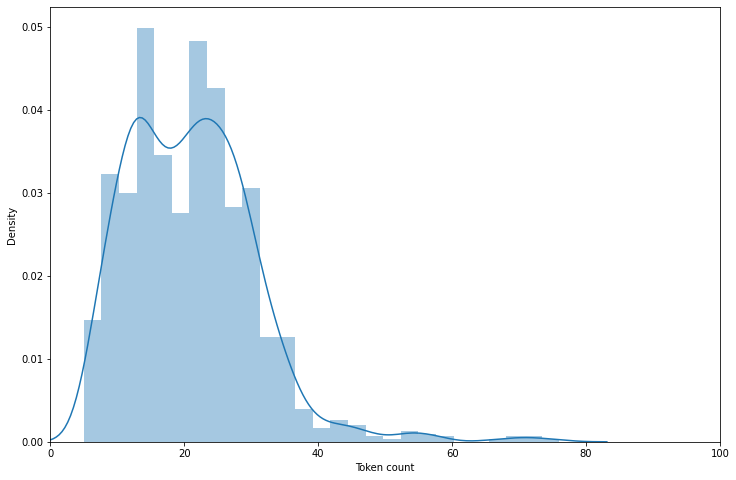

In [ ]:
token_lens = []

for txt in df.teks:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 100]);
plt.xlabel('Token count');

Dapat dilihat dari grafik diatas, sebagian besar kalimat tampaknya berisi kurang dari 90 token

In [ ]:
# Tentukan max_len
# BERT membutuhkan panjang sequence yang sama.
MAX_LEN = 90

# 06 Train & Test Split

Membagi dataset 80% untuk data latih dan 20% untuk data uji.

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

df_train.shape, df_val.shape, df_test.shape

((914, 2), (114, 2), (115, 2))

In [ ]:
# Buat fungsi untuk input formating

class FormattingDataset(Dataset):
  def __init__(self, sentences, targets, tokenizer, max_len):
    self.sentences = sentences
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.sentences)
  
  def __getitem__(self, item):
    sentence = str(self.sentences[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      sentence, 
      add_special_tokens=True,                # Tambahkan special token pada awal [CLS] dan akhir [SEP] sequence
      max_length=self.max_len,                # Tentukan max_len setiap sequence     
      pad_to_max_length=True,                 # Tambahkan padding ke max_len menggunakan [PAD] atau truncate jika sequence lebih dari max_len
      return_attention_mask=True,             # Mengembalikan nilai attention mask
      return_tensors='pt',                    # Mengembalikan PyTorch tensor
    )

    return {
      'sentence': sentence,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
# Buat fungsi untuk membuat data loader dan menerapkan input formating untuk masing-masing data latih, uji, dan validasi
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = FormattingDataset(
    sentences=df.teks.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=16,
    shuffle=True,
  )

In [ ]:
# Tentukan hyperparamter untuk fine tuning
EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 5e-5

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['sentence', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([32, 90])
torch.Size([32, 90])
torch.Size([32])


# 07 Load Pre-Trained Model

In [ ]:
print('[INFO] Loading BERT model...')
bert_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

[INFO] Loading BERT model...


Downloading:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/498M [00:00<?, ?B/s]

In [ ]:
# Lihat hidden size pada model BERT yang diload
bert_model.config.hidden_size

768

In [ ]:
bert_model.cuda()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(50000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [ ]:
# Buat fungsi BERT classifeir

class BertClassifier(nn.Module):
  def __init__(self, n_classes):
    super(BertClassifier, self).__init__()
    config = BertConfig.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.bert = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME, config=config)
    self.drop = nn.Dropout(p=0.5)   # Droput layer
    self.relu = nn.ReLU()           # Relu activation function
    self.tanh = nn.Tanh()           # TanH activation function
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)   # Dense Layer
  
  # Buat layer feed-forward classifier
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = BertClassifier(len(class_names))
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)        # batch size x seq length
print(attention_mask.shape)   # batch size x seq length

torch.Size([32, 90])
torch.Size([32, 90])


# 08 Fine Tuning

In [ ]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False, weight_decay=1e-4)   # Tentukan optimizer
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
# Buat fungsi untuk training
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
# Buat fungsi untuk evaluasi model
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

### Training Loop

In [ ]:
def average(lst): 
  return sum(lst) / len(lst) 

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

print(f'[INFO] Learning rate: {LEARNING_RATE} Batch size: {BATCH_SIZE} Total epochs: {EPOCHS}')
print('[INFO] Start training ...\n')
for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

avg_train_acc = average(history['train_acc'])
avg_train_loss = average(history['train_loss'])
avg_val_acc = average(history['val_acc'])
avg_val_loss = average(history['val_loss'])
print('[INFO] Training done ...\n')
print(f'[INFO] Average train loss: {avg_train_loss} Average train accuracy: {avg_train_acc}')
print(f'[INFO] Average   val loss: {avg_val_loss} Average   val accuracy: {avg_val_acc}\n')

[INFO] Learning rate: 5e-05 Batch size: 32 Total epochs: 5
[INFO] Start training ...

Epoch 1/5
----------
Train loss 0.4589475304659071 accuracy 0.8238512035010941
Val   loss 1.0348496735095978 accuracy 0.7894736842105263

Epoch 2/5
----------
Train loss 0.386990185441642 accuracy 0.8971553610503282
Val   loss 0.4470251202583313 accuracy 0.8771929824561403

Epoch 3/5
----------
Train loss 0.2582321136162199 accuracy 0.9277899343544858
Val   loss 0.5083424299955368 accuracy 0.9035087719298245

Epoch 4/5
----------
Train loss 0.1615887288453764 accuracy 0.9638949671772429
Val   loss 0.5689719244837761 accuracy 0.894736842105263

Epoch 5/5
----------
Train loss 0.11560832270710118 accuracy 0.9770240700218819
Val   loss 0.5082597916480154 accuracy 0.9035087719298245

[INFO] Training done ...

[INFO] Average train loss: 0.2762733762152493 Average train accuracy: 0.9179431072210067
[INFO] Average   val loss: 0.6134897879790515 Average   val accuracy: 0.8736842105263158

CPU times: user 46.8

# 09 Model Evaluation

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9478260869565217

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  sentences = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["sentence"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      sentences.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sentences, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      normal       0.98      0.98      0.98        50
       fraud       0.97      0.90      0.94        42
       promo       0.85      0.96      0.90        23

    accuracy                           0.95       115
   macro avg       0.93      0.95      0.94       115
weighted avg       0.95      0.95      0.95       115



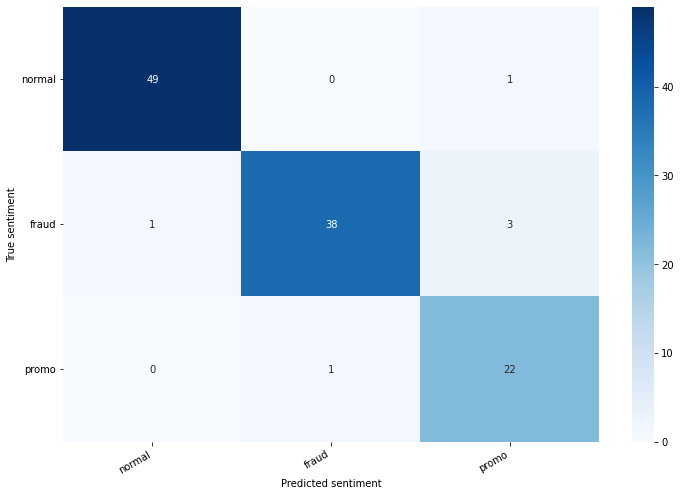

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 40 # sample data in test data

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

gtshop disc bb z jt bb torch jt bb davis jt minat galaxy s jt cp pinab
gilisms versi demo

True sentiment: fraud


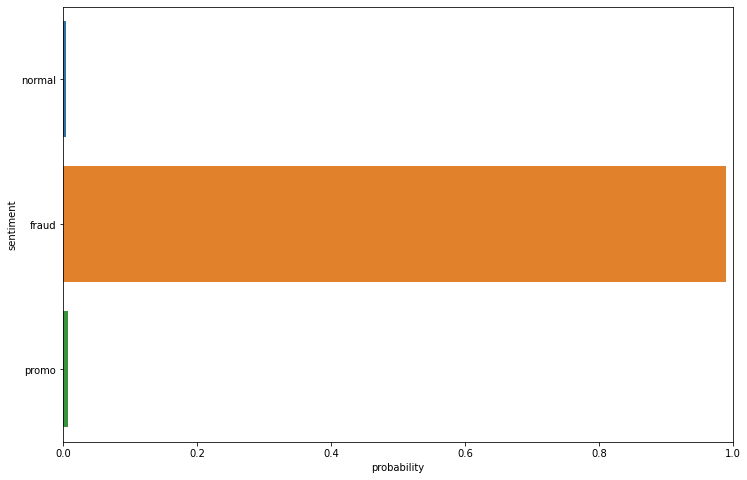

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

# 10 Predicting on Raw Text

Menggunakan model BERT yang telah di *fine-tuning* untuk memprediksi kalimat baru.

In [ ]:
raw_text = "Dapatkan diskon 10% semua produk, promo setiap hari."

In [ ]:
encoded_sentence = tokenizer.encode_plus(
  raw_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_sentence['input_ids'].to(device)
attention_mask = encoded_sentence['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Text: {raw_text}')
print(f'Sentiment  : {class_names[prediction]}')

Text: Dapatkan diskon 10% semua produk, promo setiap hari.
Sentiment  : promo
